In [164]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


<h4>Константы<h4>

In [165]:
PATH = 'cybersequrity.csv'
RANDOM_STATE = 42
EPOCHS=20

<h4>Просмотр данных<h4>

In [166]:
data = pd.read_csv(PATH)
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   svcscan.fs_drivers                      10000 non-null  int64  
 1   callbacks.ngeneric                      10000 non-null  int64  
 2   psxview.not_in_eprocess_pool_false_avg  10000 non-null  float64
 3   psxview.not_in_eprocess_pool            10000 non-null  int64  
 4   callbacks.nanonymous                    10000 non-null  int64  
 5   psxview.not_in_session                  10000 non-null  int64  
 6   psxview.not_in_pslist                   10000 non-null  int64  
 7   psxview.not_in_pspcid_list              10000 non-null  int64  
 8   psxview.not_in_ethread_pool             10000 non-null  int64  
 9   psxview.not_in_csrss_handles            10000 non-null  int64  
 10  psxview.not_in_pslist_false_avg         10000 non-null  flo

(   svcscan.fs_drivers  callbacks.ngeneric  \
 0                  26                   8   
 1                  26                   8   
 2                  26                   8   
 3                  26                   8   
 4                  26                   8   
 
    psxview.not_in_eprocess_pool_false_avg  psxview.not_in_eprocess_pool  \
 0                                     0.0                             0   
 1                                     0.0                             0   
 2                                     0.0                             0   
 3                                     0.0                             0   
 4                                     0.0                             0   
 
    callbacks.nanonymous  psxview.not_in_session  psxview.not_in_pslist  \
 0                     0                       2                      0   
 1                     0                       5                      3   
 2                     0               

In [167]:
X = data.drop(columns=['Class'])
y = data['Class']

<h4>Разделение датасета<h4>

In [168]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

Стандартизация функции с помощью StandardScaler

In [169]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Проверка размеров

In [170]:
len(X_train), len(X_val), len(X_test)

(6000, 2000, 2000)

Данные разделены:

Обучающая выборка: 6000 

Валидационная выборка: 2000 

Тестовая выборка: 2000 

In [171]:
class MalwareDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<h4>Создание датасета<h4>

In [172]:
train_dataset = MalwareDataset(X_train_scaled, y_train)
val_dataset = MalwareDataset(X_val_scaled, y_val)
test_dataset = MalwareDataset(X_test_scaled, y_test)

In [173]:
batch_size = 64

Это стандартный размер батча, который эффективно работает на большинстве задач. Он достаточен для стабильного обучения, при этом не слишком велик, чтобы не перегрузить память.

Создание Data Loaders

In [174]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Проверка одного пакета

In [175]:
next(iter(train_loader))

[tensor([[ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
          -2.7900e-01, -2.7917e-01, -2.7905e-01,  1.2439e+01,  1.2432e+01,
          -5.3210e-01, -5.3195e-01,  1.2104e+01,  7.9724e+00, -1.0605e+00],
         [ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
          -6.1347e-01, -6.1364e-01, -6.1352e-01, -4.9217e-01, -4.9267e-01,
          -7.0467e-01, -7.0452e-01, -4.7654e-01, -7.0482e-01, -7.6535e-01],
         [ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
          -2.7900e-01, -2.7917e-01, -2.7905e-01, -2.7301e-01, -2.7361e-01,
          -2.9659e-01, -2.9644e-01, -2.6331e-01, -3.5703e-01, -3.2197e-01],
         [ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
           5.5466e-02,  5.5299e-02,  5.5410e-02, -5.3842e-02, -5.4547e-02,
           1.5395e-01,  1.5410e-01, -5.0074e-02,  2.6946e-02,  1.9338e-01],
         [ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
           3.8993e-01

<h4>Базовый класс модели<h4>

In [176]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

Инициализация

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel(input_dim=X_train_scaled.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Описание модели

In [178]:
print(model)

MLPModel(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


<h4>Циклы обучения и валидации<h4>

In [179]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
       
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

<h4>Обучение модели<h4>

In [180]:
model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch [1/20], Train Loss: 0.6798, Val Loss: 0.6684
Epoch [2/20], Train Loss: 0.6632, Val Loss: 0.6571
Epoch [3/20], Train Loss: 0.6527, Val Loss: 0.6495
Epoch [4/20], Train Loss: 0.6446, Val Loss: 0.6433
Epoch [5/20], Train Loss: 0.6384, Val Loss: 0.6374
Epoch [6/20], Train Loss: 0.6318, Val Loss: 0.6322
Epoch [7/20], Train Loss: 0.6269, Val Loss: 0.6238
Epoch [8/20], Train Loss: 0.6200, Val Loss: 0.6167
Epoch [9/20], Train Loss: 0.6135, Val Loss: 0.6110
Epoch [10/20], Train Loss: 0.6067, Val Loss: 0.6037
Epoch [11/20], Train Loss: 0.5989, Val Loss: 0.5972
Epoch [12/20], Train Loss: 0.5922, Val Loss: 0.5905
Epoch [13/20], Train Loss: 0.5868, Val Loss: 0.5832
Epoch [14/20], Train Loss: 0.5796, Val Loss: 0.5768
Epoch [15/20], Train Loss: 0.5749, Val Loss: 0.5710
Epoch [16/20], Train Loss: 0.5683, Val Loss: 0.5650
Epoch [17/20], Train Loss: 0.5630, Val Loss: 0.5597
Epoch [18/20], Train Loss: 0.5589, Val Loss: 0.5551
Epoch [19/20], Train Loss: 0.5542, Val Loss: 0.5503
Epoch [20/20], Train 

<h4>Визуализация обучения и валидации<h4>

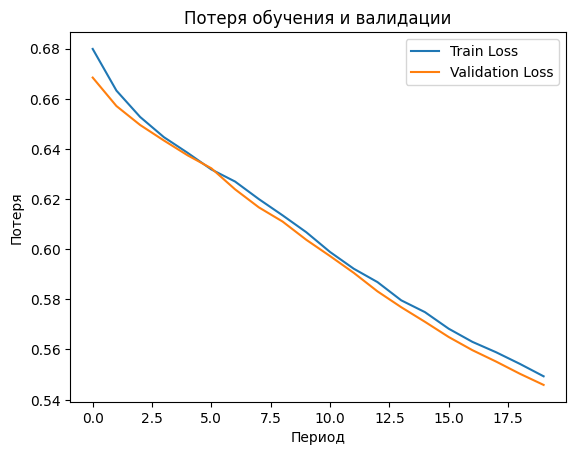

In [181]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Период')
plt.ylabel('Потеря')
plt.legend()
plt.title('Потеря обучения и валидации')
plt.show()

<h4>Оценка модели на тестовой выборки<h4>

In [182]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)
            preds = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return classification_report(all_labels, all_preds)


In [183]:
classification_report_str = evaluate_model(model, test_loader)
print(classification_report_str)

              precision    recall  f1-score   support

         0.0       0.73      0.78      0.76       981
         1.0       0.78      0.73      0.75      1019

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.75      2000
weighted avg       0.76      0.76      0.75      2000



<h4>Улучшение модели (BatchNorm и Dropout)<h4>

In [184]:
class ImprovedMLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout_prob=0.3):
        super(ImprovedMLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

<h4>Инициализатор<h4>

In [185]:
model = ImprovedMLPModel(input_dim=X_train_scaled.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h4>Обучение улучшенной модели<h4>

In [186]:
model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch [1/20], Train Loss: 0.6536, Val Loss: 0.6478
Epoch [2/20], Train Loss: 0.6097, Val Loss: 0.6258
Epoch [3/20], Train Loss: 0.5741, Val Loss: 0.5853
Epoch [4/20], Train Loss: 0.5635, Val Loss: 0.5744
Epoch [5/20], Train Loss: 0.5501, Val Loss: 0.5498
Epoch [6/20], Train Loss: 0.5492, Val Loss: 0.5697
Epoch [7/20], Train Loss: 0.5301, Val Loss: 0.5948
Epoch [8/20], Train Loss: 0.5324, Val Loss: 0.5813
Epoch [9/20], Train Loss: 0.5258, Val Loss: 0.5668
Epoch [10/20], Train Loss: 0.5248, Val Loss: 0.5523
Epoch [11/20], Train Loss: 0.5223, Val Loss: 0.6103
Epoch [12/20], Train Loss: 0.5197, Val Loss: 0.5157
Epoch [13/20], Train Loss: 0.5246, Val Loss: 0.5785
Epoch [14/20], Train Loss: 0.5234, Val Loss: 0.4883
Epoch [15/20], Train Loss: 0.5101, Val Loss: 0.5441
Epoch [16/20], Train Loss: 0.5105, Val Loss: 0.5248
Epoch [17/20], Train Loss: 0.5114, Val Loss: 0.5392
Epoch [18/20], Train Loss: 0.5118, Val Loss: 0.5329
Epoch [19/20], Train Loss: 0.5081, Val Loss: 0.5406
Epoch [20/20], Train 

<h4>Визуализация улучшенной модели<h4>

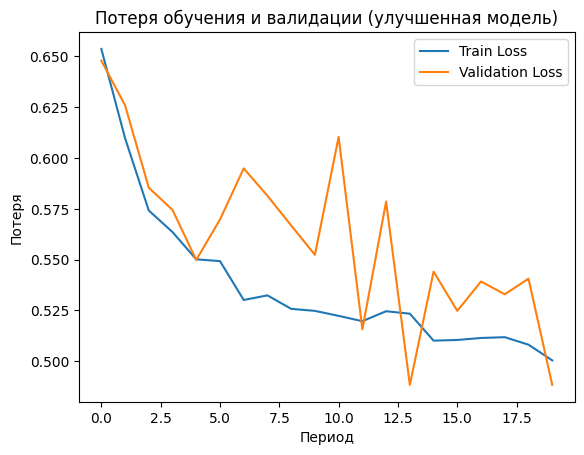

In [187]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Период')
plt.ylabel('Потеря')
plt.legend()
plt.title('Потеря обучения и валидации (улучшенная модель)')
plt.show()

<h4>Оценка улучшенной модели<h4>

In [188]:
classification_report_str = evaluate_model(model, test_loader)
print(classification_report_str)

              precision    recall  f1-score   support

         0.0       0.82      0.64      0.72       981
         1.0       0.72      0.86      0.78      1019

    accuracy                           0.75      2000
   macro avg       0.77      0.75      0.75      2000
weighted avg       0.76      0.75      0.75      2000



После обучения модели на тренировочных и валидационных данных, измеряю её качество на тестовой выборке с помощью classification_report, который дает подробную информацию о точности, полноте, F1-мере и других метриках.

Precision и Recall важны в задачах классификации вредоносного ПО, где важно минимизировать как ложные срабатывания, так и пропуски.